# Team Challenge Image Analysis - Team 6

This notebook shows an example workflow for the proposed image analysis software, it consists of two parts: training and evaluation. More information about the setup and file structure can be found on the Github page.

## Part 0: Setup
In this part, the general setup for the workflow will be done. This consists of changing the working directory to be `root` and performing relevant imports. 

In [1]:
# Change working directory to the root folder
import os, sys
if os.path.split(os.getcwd())[-1] != 'TeamChallenge_team6':
    %cd ..
    
    if os.path.split(os.getcwd())[-1] != 'TeamChallenge_team6':
        raise UserError("Something went wrong in the directory reassignment!")

# Add relevant directories to path
if "" not in sys.path : sys.path.append("")
if "src" not in sys.path : sys.path.append("src")

D:\Users\sjors\Documents\TUe\MSc\TeamChallenge\TeamChallenge_team6


In [2]:
# Relevant imports
import os
from data_preperation import data_prep, inspect_data
from preprocessing import preprocess_data
from model import define_discriminator, define_generator, define_gan
from training import train
from evaluation import evaluate, get_fsl_metrics, resp_vec_correlation, calc_def_scores
from util.tf_session import setup_tf_session
from util.general import *

# Setup the tf session for possible gpu usage
n_gpus = setup_tf_session()

Using TensorFlow backend.


## Part 1: Training
In this part, the cGAN model will be trained. It will do so by first preprocessing the data, after which the datasets will be loaded and the models are defined. Hereafter, the actual training process is performed. By default, we'll be training for 100 epochs with a batch size of 4 and an augmentation factor of 20. 

### 1a: Data preprocessing

In [3]:
preprocess_data("data", verbose=True)

Performing data preprocessing in directory:
D:\Users\sjors\Documents\TUe\MSc\TeamChallenge\TeamChallenge_team6\data


100%|#################################################################################| 22/22 [00:00<00:00, 127.17it/s]


### 1b: Dataset generation

##### Data loading

In [4]:
# Load data
print("Dataset - TRAIN")
dataset_train, train_subjects = data_prep(os.path.join("data", "preprocessed"), True, "train", verbose=True)
print("Dataset - TEST")
dataset_test, test_subjects = data_prep(os.path.join("data", "preprocessed"), True, "test", verbose=True)

# Define image shape
image_shape = dataset_train[0].shape[1:]
image_shape = (image_shape[0], image_shape[1], 1)

Dataset - TRAIN
Extracting data for subject 'rat29' (1/16)...	Completed
Extracting data for subject 'rat71' (2/16)...	Completed
Extracting data for subject 'rat32' (3/16)...	Completed
Extracting data for subject 'rat34' (4/16)...	Completed
Extracting data for subject 'rat72' (5/16)...	Completed
Extracting data for subject 'rat96' (6/16)...	Completed
Extracting data for subject 'rat25' (7/16)...	Completed
Extracting data for subject 'rat31' (8/16)...	Completed
Extracting data for subject 'rat63' (9/16)...	Completed
Extracting data for subject 'rat35' (10/16)...	Completed
Extracting data for subject 'rat61' (11/16)...	Completed
Extracting data for subject 'rat84' (12/16)...	Completed
Extracting data for subject 'rat70' (13/16)...	Completed
Extracting data for subject 'rat26' (14/16)...	Completed
Extracting data for subject 'rat62' (15/16)...	Completed
Extracting data for subject 'rat89' (16/16)...	Completed

Completed data extraction!
Found a total of 48 slices

Dataset - TEST
Extracting

##### Data inspection
We will now also have a look at some of the preprocessed images for quality assurance and a better understanding in the inner workings of the pipeline. Please note that here, the left image is the day 3 image (input), while the right image is the day 0 image (target). You'll notice that the image used are brain extracted and cropped in such a way as to center the brain as much as possible. Also, a histogram equalization is performed to yield better image contrast.

To decrease the problem complexity, please note that we're using 2D data and are focussing on the center three z-slices. 

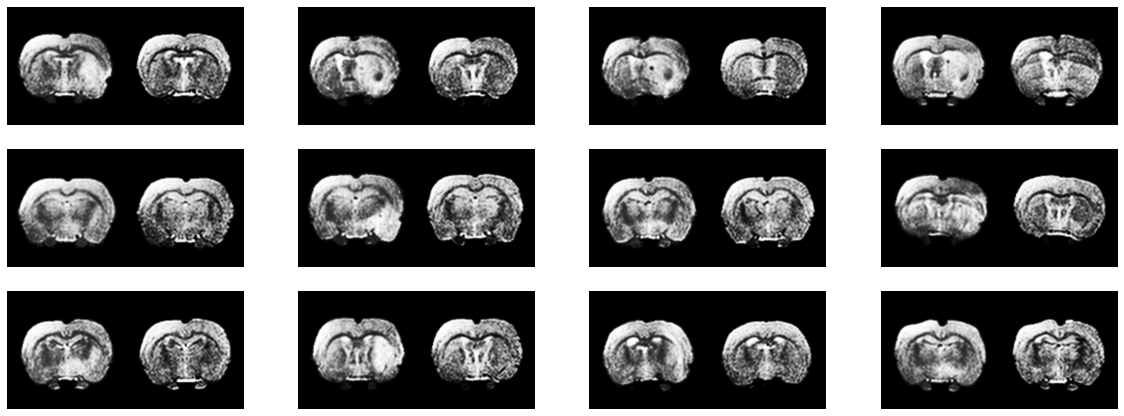

In [5]:
inspect_data(dataset_train, n_samples = 12)

### 1c: Model definition

In [6]:
# Define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)

# Show model summaries
print(print_style.BOLD+"=== DISCRIMINATOR MODEL ==="+print_style.END)
d_model.summary()
print(print_style.BOLD+"\n\n===== GENERATOR MODEL ====="+print_style.END)
g_model.summary()
print(print_style.BOLD+"\n\n======== GAN MODEL ========"+print_style.END)
gan_model.summary()

=== DISCRIMINATOR MODEL ===
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 2112       

D:\ProgramData\Anaconda3\envs\TeamChallenge\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### 1d: Actual training
Here, we will run the actual training. Augmentation will be performed by default, with an augmentation factor of 20. The batch size and number of epochs are 4 and 100, respectively. An Adam optimizer is used, and the loss function is comprised of binary crossentropy (discriminator), the mean average error (generator), and a SSIM loss term (1-SSIM) (generator). 

In [7]:
# Train model
run_name = train(d_model, g_model, gan_model, dataset_train, n_epochs=100, n_batch=4)


Epoch 1/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:36<00:00,  1.96it/s]


>Losses: d1[0.367] d2[0.367] g[2.908]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0000191.h5s

Epoch 2/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:09<00:00,  2.73it/s]


>Losses: d1[0.352] d2[0.372] g[1.708]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0000381.h5s

Epoch 3/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:07<00:00,  2.80it/s]


>Losses: d1[0.349] d2[0.387] g[1.710]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0000571.h5s

Epoch 4/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:08<00:00,  2.79it/s]


>Losses: d1[0.371] d2[0.366] g[1.314]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0000761.h5s

Epoch 5/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.351] d2[0.373] g[1.207]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0000951.h5s

Epoch 6/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:06<00:00,  2.87it/s]


>Losses: d1[0.355] d2[0.366] g[1.326]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0001141.h5s

Epoch 7/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.01it/s]


>Losses: d1[0.343] d2[0.372] g[1.390]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0001331.h5s

Epoch 8/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.00it/s]


>Losses: d1[0.348] d2[0.370] g[1.182]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0001521.h5s

Epoch 9/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.00it/s]


>Losses: d1[0.355] d2[0.358] g[1.399]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0001711.h5s

Epoch 10/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.01it/s]


>Losses: d1[0.344] d2[0.367] g[1.435]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0001901.h5s

Epoch 11/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.01it/s]


>Losses: d1[0.339] d2[0.365] g[1.276]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0002091.h5s

Epoch 12/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.00it/s]


>Losses: d1[0.350] d2[0.358] g[1.297]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0002281.h5s

Epoch 13/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.99it/s]


>Losses: d1[0.353] d2[0.354] g[1.379]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0002471.h5s

Epoch 14/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.302] d2[0.363] g[2.093]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0002661.h5s

Epoch 15/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.358] d2[0.360] g[1.469]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0002851.h5s

Epoch 16/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.344] d2[0.355] g[1.374]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0003041.h5s

Epoch 17/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.363] d2[0.365] g[1.174]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0003231.h5s

Epoch 18/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.348] d2[0.361] g[1.432]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0003421.h5s

Epoch 19/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.97it/s]


>Losses: d1[0.368] d2[0.370] g[1.168]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0003611.h5s

Epoch 20/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.351] d2[0.364] g[1.303]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0003801.h5s

Epoch 21/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.349] d2[0.356] g[1.576]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0003991.h5s

Epoch 22/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.336] d2[0.348] g[1.478]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0004181.h5s

Epoch 23/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.260] d2[0.298] g[2.166]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0004371.h5s

Epoch 24/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.360] d2[0.401] g[1.678]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0004561.h5s

Epoch 25/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.363] d2[0.356] g[1.544]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0004751.h5s

Epoch 26/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.337] d2[0.363] g[1.339]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0004941.h5s

Epoch 27/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.270] d2[0.348] g[2.135]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0005131.h5s

Epoch 28/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.94it/s]


>Losses: d1[0.167] d2[0.223] g[2.934]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0005321.h5s

Epoch 29/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.97it/s]


>Losses: d1[0.206] d2[0.081] g[3.545]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0005511.h5s

Epoch 30/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.376] d2[0.360] g[1.446]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0005701.h5s

Epoch 31/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.344] d2[0.352] g[1.639]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0005891.h5s

Epoch 32/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.144] d2[0.377] g[2.315]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0006081.h5s

Epoch 33/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.93it/s]


>Losses: d1[0.194] d2[0.220] g[2.771]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0006271.h5s

Epoch 34/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.144] d2[0.408] g[3.240]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0006461.h5s

Epoch 35/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.104] d2[0.281] g[3.442]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0006651.h5s

Epoch 36/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.100] d2[0.326] g[3.277]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0006841.h5s

Epoch 37/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.94it/s]


>Losses: d1[0.149] d2[0.069] g[3.862]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0007031.h5s

Epoch 38/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.064] d2[0.136] g[3.700]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0007221.h5s

Epoch 39/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.232] d2[0.457] g[3.985]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0007411.h5s

Epoch 40/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.184] d2[0.110] g[3.897]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0007601.h5s

Epoch 41/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.93it/s]


>Losses: d1[0.287] d2[0.081] g[3.699]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0007791.h5s

Epoch 42/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.074] d2[0.120] g[4.015]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0007981.h5s

Epoch 43/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.189] d2[0.367] g[4.276]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0008171.h5s

Epoch 44/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  3.00it/s]


>Losses: d1[0.133] d2[0.234] g[4.585]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0008361.h5s

Epoch 45/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.099] d2[0.054] g[4.422]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0008551.h5s

Epoch 46/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:11<00:00,  2.67it/s]


>Losses: d1[0.087] d2[0.065] g[4.140]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0008741.h5s

Epoch 47/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.065] d2[0.495] g[3.863]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0008931.h5s

Epoch 48/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.083] d2[0.371] g[3.914]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0009121.h5s

Epoch 49/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.118] d2[0.250] g[4.292]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0009311.h5s

Epoch 50/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.338] d2[0.076] g[3.899]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0009501.h5s

Epoch 51/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.346] d2[0.087] g[4.175]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0009691.h5s

Epoch 52/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.96it/s]


>Losses: d1[0.126] d2[0.227] g[3.668]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0009881.h5s

Epoch 53/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.069] d2[0.364] g[3.394]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0010071.h5s

Epoch 54/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.079] d2[0.236] g[3.770]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0010261.h5s

Epoch 55/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.172] d2[0.264] g[4.111]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0010451.h5s

Epoch 56/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.97it/s]


>Losses: d1[0.498] d2[0.066] g[4.274]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0010641.h5s

Epoch 57/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.195] d2[0.287] g[3.620]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0010831.h5s

Epoch 58/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.99it/s]


>Losses: d1[0.117] d2[0.194] g[3.771]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0011021.h5s

Epoch 59/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.97it/s]


>Losses: d1[0.119] d2[0.248] g[4.170]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0011211.h5s

Epoch 60/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.085] d2[0.234] g[3.962]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0011401.h5s

Epoch 61/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.99it/s]


>Losses: d1[0.103] d2[0.105] g[3.915]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0011591.h5s

Epoch 62/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.358] d2[0.236] g[4.444]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0011781.h5s

Epoch 63/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.142] d2[0.384] g[4.001]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0011971.h5s

Epoch 64/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.99it/s]


>Losses: d1[0.054] d2[0.121] g[4.167]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0012161.h5s

Epoch 65/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.980] d2[0.071] g[4.084]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0012351.h5s

Epoch 66/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.274] d2[0.068] g[4.393]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0012541.h5s

Epoch 67/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.062] d2[0.101] g[4.179]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0012731.h5s

Epoch 68/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.121] d2[0.163] g[4.099]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0012921.h5s

Epoch 69/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.216] d2[0.429] g[4.162]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0013111.h5s

Epoch 70/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.99it/s]


>Losses: d1[0.028] d2[0.200] g[4.302]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0013301.h5s

Epoch 71/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.98it/s]


>Losses: d1[0.042] d2[0.302] g[4.137]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0013491.h5s

Epoch 72/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:03<00:00,  2.97it/s]


>Losses: d1[0.121] d2[0.245] g[4.023]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0013681.h5s

Epoch 73/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.93it/s]


>Losses: d1[0.141] d2[0.371] g[3.885]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0013871.h5s

Epoch 74/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.97it/s]


>Losses: d1[0.044] d2[0.280] g[4.189]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0014061.h5s

Epoch 75/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.95it/s]


>Losses: d1[0.037] d2[0.411] g[4.475]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0014251.h5s

Epoch 76/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.94it/s]


>Losses: d1[0.089] d2[0.242] g[4.293]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0014441.h5s

Epoch 77/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.135] d2[0.085] g[4.160]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0014631.h5s

Epoch 78/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.132] d2[0.125] g[4.028]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0014821.h5s

Epoch 79/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.103] d2[0.209] g[4.180]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0015011.h5s

Epoch 80/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.92it/s]


>Losses: d1[0.074] d2[0.103] g[4.040]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0015201.h5s

Epoch 81/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.90it/s]


>Losses: d1[0.127] d2[0.077] g[4.350]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0015391.h5s

Epoch 82/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.92it/s]


>Losses: d1[0.307] d2[0.069] g[4.144]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0015581.h5s

Epoch 83/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.92it/s]


>Losses: d1[0.078] d2[0.124] g[4.345]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0015771.h5s

Epoch 84/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.90it/s]


>Losses: d1[0.039] d2[0.121] g[4.799]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0015961.h5s

Epoch 85/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.149] d2[0.087] g[4.302]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0016151.h5s

Epoch 86/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.90it/s]


>Losses: d1[0.069] d2[0.278] g[4.165]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0016341.h5s

Epoch 87/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.043] d2[0.273] g[4.286]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0016531.h5s

Epoch 88/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.93it/s]


>Losses: d1[0.397] d2[0.363] g[2.662]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0016721.h5s

Epoch 89/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.93it/s]


>Losses: d1[0.445] d2[0.215] g[2.746]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0016911.h5s

Epoch 90/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.225] d2[0.101] g[3.771]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0017101.h5s

Epoch 91/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:04<00:00,  2.94it/s]


>Losses: d1[0.120] d2[0.225] g[3.672]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0017291.h5s

Epoch 92/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.92it/s]


>Losses: d1[0.153] d2[0.139] g[3.775]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0017481.h5s

Epoch 93/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.92it/s]


>Losses: d1[0.123] d2[0.091] g[4.418]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0017671.h5s

Epoch 94/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.070] d2[0.093] g[4.316]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0017861.h5s

Epoch 95/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.053] d2[0.306] g[4.730]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0018051.h5s

Epoch 96/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.90it/s]


>Losses: d1[0.121] d2[0.267] g[4.002]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0018241.h5s

Epoch 97/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.90it/s]


>Losses: d1[0.067] d2[0.309] g[4.578]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0018431.h5s

Epoch 98/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.91it/s]


>Losses: d1[0.081] d2[0.160] g[4.606]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0018621.h5s

Epoch 99/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.89it/s]


>Losses: d1[0.088] d2[0.125] g[4.292]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0018811.h5s

Epoch 100/100:
Performing data augmentation... Completed


100%|################################################################################| 190/190 [01:05<00:00,  2.90it/s]


>Losses: d1[0.051] d2[0.281] g[4.452]
>Saved model: models\run_2021-04-02_17-18-03\g_model_0019001.h5s


## Part 2: Evaluation

Based on the training we did above, we can evaluate the best performing model. First choose which model (based on step) you want to evaluate (e.g. "0029400"), you can do this by typing the following into your prompt (with specified path to logs): 

`tensorboard --logdir "../logs"`

and go to http://localhost:6006/

The step which resulted in the best performing step can be specified in the specific_model parameter below to evaluate the correpsonding model ("last" argument results in evaluating the model from the last step).

### Correlation analysis
Firstly, let's run our training set through the generator model and calculate the SSIM scores. We will then compare these scores to SSIM and DSC scores from the FSL run (Bart's method) and the response vector data through a correlation analysis. This is done, since it is expected that all of these features will in some way quantify the edema-related deformation in a specific subject. We will display this analysis in a set of scatter plots. Here, it should be noted that the 'darkness' of the plot is directly proportional to the correlation between those two features.

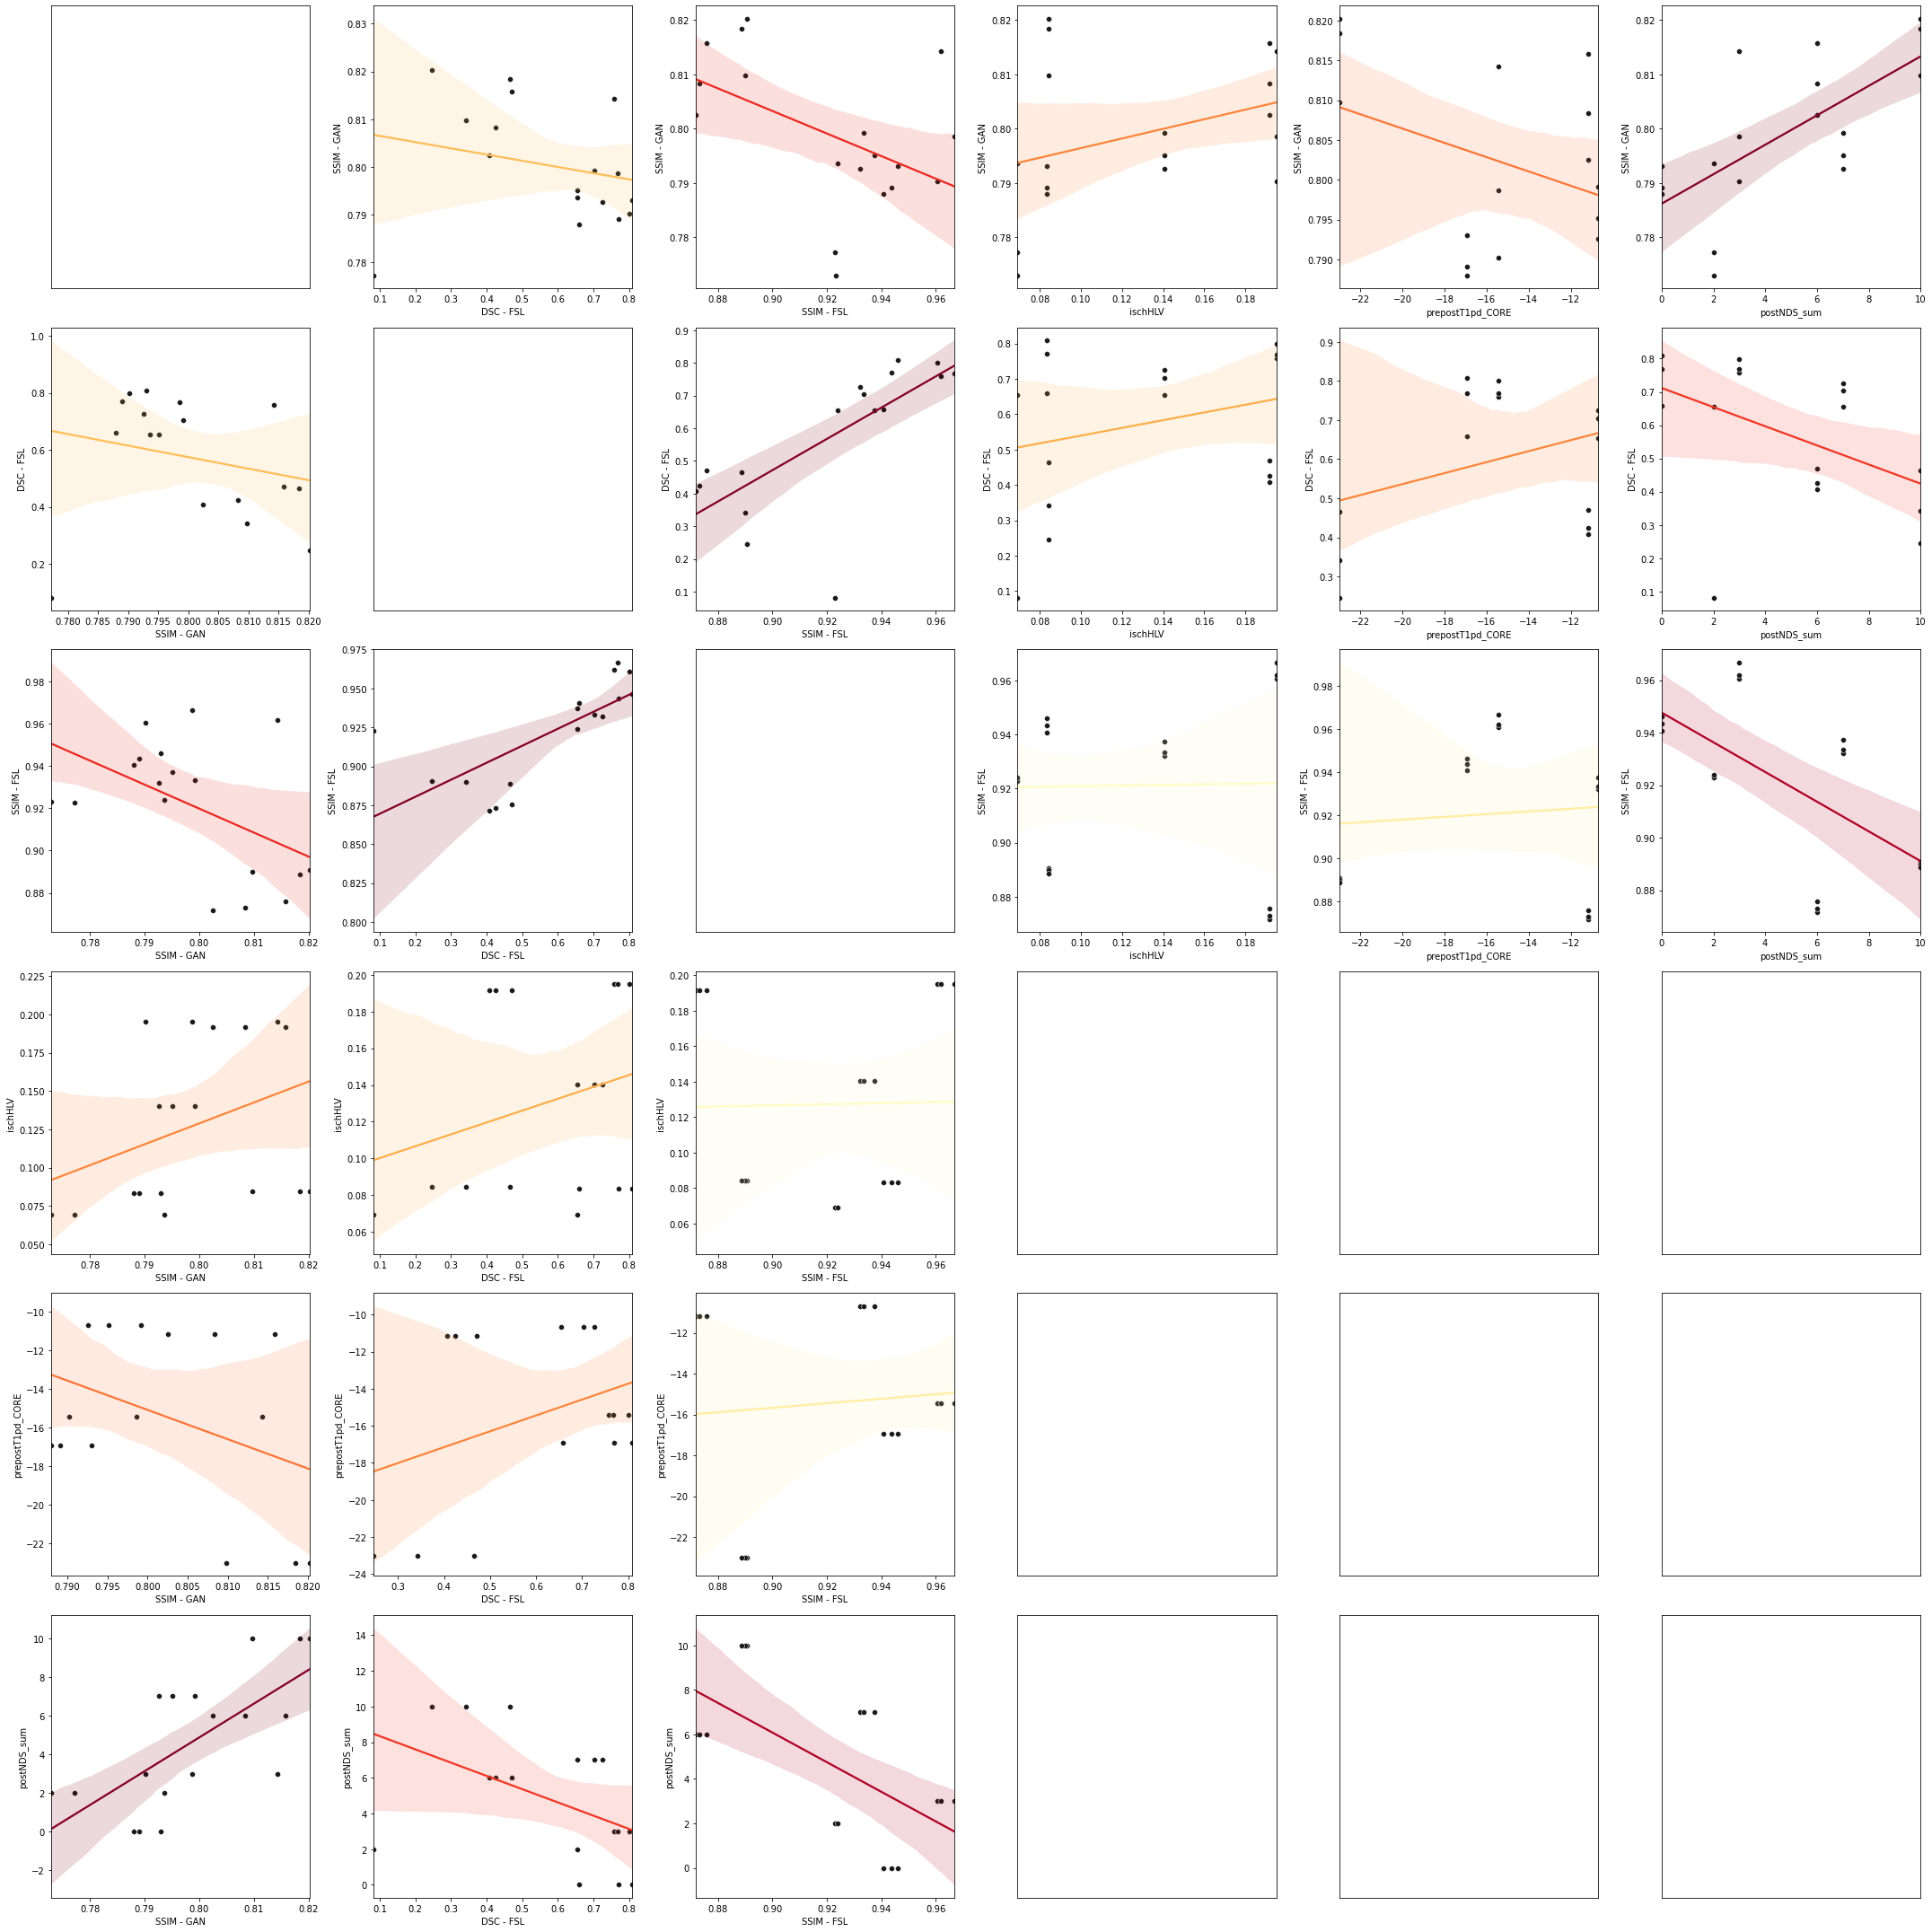

In [8]:
# Calculate SSIM for our cGAN method
eval_model = "0019001"

eval_SSIMs = evaluate(d_model, g_model, gan_model, dataset_test, test_subjects, time=run_name, specific_model=eval_model)

# Calculate SSIM and DSC for the FSL method (Bart's method)
fsl_SSIM, fsl_DSC = get_fsl_metrics("data", test_subjects)

# Perform correlation analysis and display figure
resp_vec_cor = resp_vec_correlation("data", test_subjects, eval_SSIMs)

### Show results
Now, let's calculate and display some results for our method. Here, note that we will not present the results of all available subjects. Instead, we will show the results of our test subjects. The results are presented in a couple of plots. Different slices of the test subject are given in rows, while the columns represent the generated day0 image, true day0 image, true day4 image and estimated deformation map (so between fake day0 and true day4), respectively.

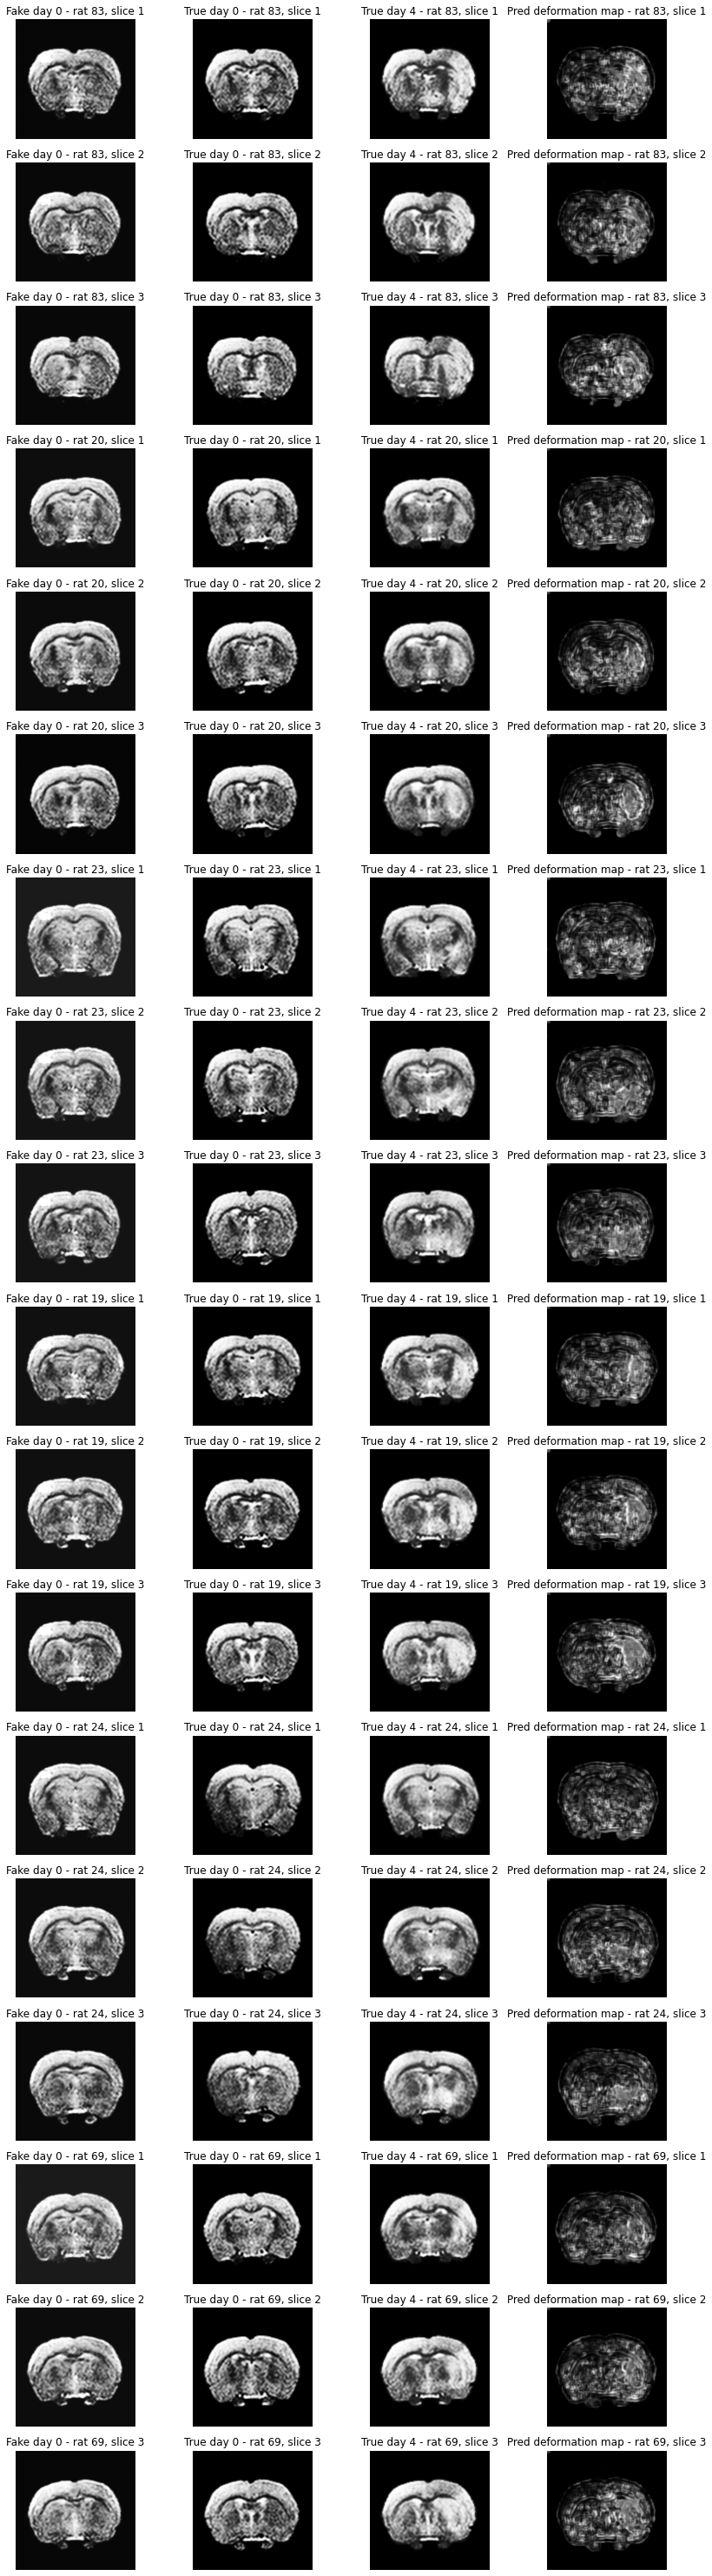

In [9]:
eval_SSIMs = evaluate(d_model, g_model, gan_model, dataset_test, test_subjects, time=run_name, specific_model=eval_model, show_fig=True)

Additionally, the SSIM scores between the true day3 and fake day0 images give a quantification for deformation. Here, note that deformation is given in a range of `[0, 1]`. The higher the deformation, the higher this number should be. The 'deformation' score is a direct linear transform of the SSIM score.

In [10]:
deformation_scores = calc_def_scores(eval_SSIMs, test_subjects, verbose=True)

Deformation for subject 83:	0.2055 [0-1]
Deformation for subject 20:	0.1980 [0-1]
Deformation for subject 23:	0.1900 [0-1]
Deformation for subject 19:	0.1836 [0-1]
Deformation for subject 24:	0.1931 [0-1]
Deformation for subject 69:	0.2039 [0-1]
